<h2 align="center">BERT tutorial: Classify spam vs no spam emails</h2>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

2023-06-21 14:57:41.797814: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 14:57:46.709184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 14:57:46.713657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 14:57:56.857436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
747/4825

0.15481865284974095

**15% spam emails, 85% ham emails: This indicates class imbalance**

In [5]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [6]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [7]:
# returns total number of rows in the dataframe that are spam emails
df_spam.shape[0]

747

In [8]:
# sample() returns a random sample of items from an axis of object.
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [11]:
df_balanced['CategoryNum']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,CategoryNum
4139,ham,"Good! No, don‘t need any receipts—well done! (...",0
3577,ham,The sign of maturity is not when we start sayi...,0
3856,spam,Free msg: Single? Find a partner in your area!...,1
3266,spam,"44 7732584351, Do you want a New Nokia 3510i c...",1
4760,spam,Thanks 4 your continued support Your question ...,1


<h4>Split it into training and test data set</h4>

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['CategoryNum'], stratify=df_balanced['CategoryNum'])
# stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.
y_train.shape
# y_test.shape
# X_test.shape

(1120,)

In [13]:
X_train.head(4)

1397                             Shall i start from hear.
3483    Do you want a NEW video phone750 anytime any n...
3784                       Can you do online transaction?
2830    Send a logo 2 ur lover - 2 names joined by a h...
Name: Message, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [14]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2023-06-21 15:02:38.716458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-21 15:02:38.717334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-21 15:02:38.717558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-21 15:02:38.718396: I tensorflow/core/

In [15]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    # pooled_output is the embedding vector for the entire sentence
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.88845724, ..., -0.74748874,
        -0.75314736,  0.91964483],
       [-0.8720836 , -0.5054398 , -0.9444668 , ..., -0.85847515,
        -0.7174535 ,  0.88082975]], dtype=float32)>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

In [16]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])
# embedding vector size for each words is 768
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606919 , -0.14219381,  0.4960461 , ...,  0.42165333,
        -0.532214  ,  0.80312175],
       [-0.86023223, -0.21242939,  0.4915689 , ...,  0.3979803 ,
        -0.60506296,  0.8447167 ],
       [-0.7128864 , -0.15463923,  0.38401636, ...,  0.352787  ,
        -0.5099134 ,  0.73474115],
       [-0.8253345 , -0.3555054 , -0.5906963 , ..., -0.01613662,
        -0.6141756 ,  0.87230295],
       [-0.7504134 , -0.26812598, -0.26689604, ...,  0.02839445,
        -0.5938098 ,  0.79749876],
       [-0.78544384, -0.299497  ,  0.41027427, ...,  0.5222542 ,
        -0.4957355 ,  0.81507534]], dtype=float32)>

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [19]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [20]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872034]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

<h4>Build Model</h4>

There are two types of models you can build in tensorflow. 

(1) Sequential
(2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Bert layers
# Input means what kind of input we are going to give to the model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

2023-06-21 15:18:17.333586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-06-21 15:18:17.436736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?,128]
	 [[{{node Placeholder_1}}]]
2023-06-21 15:18:17.436918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_2' with dtype int32 and shape [?,128]
	 [[{{node

https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [28]:
len(X_train)

1120

In [27]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
# binary_crossentropy is used for binary classification, if there are more than 2 classes then use categorical_crossentropy
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [28]:
# verbose = 1 means it will show the progress bar
model.fit(X_train, y_train, epochs=2, verbose=1)
# model.fit(X_train, y_train, epochs=10, verbose=1)
# ignore all warnings of tensorflow

Epoch 1/2


2023-06-21 15:22:25.617046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_3}}]]
2023-06-21 15:22:25.617189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_4}}]]
2023

35/35 [==============================] - 7615s 223s/step - loss: 0.6344 - accuracy: 0.6402 - precision: 0.6342 - recall: 0.6625
Epoch 2/2
35/35 [==============================] - 614s 18s/step - loss: 0.4901 - accuracy: 0.8473 - precision: 0.8505 - recall: 0.8429


In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 4s 194ms/step - loss: 0.2600 - accuracy: 0.9064 - precision: 0.8486 - recall: 0.9893


[0.2599719762802124,
 0.9064171314239502,
 0.8486238718032837,
 0.9893048405647278]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[154,  33],
       [  2, 185]], dtype=int64)

Text(33.0, 0.5, 'Truth')

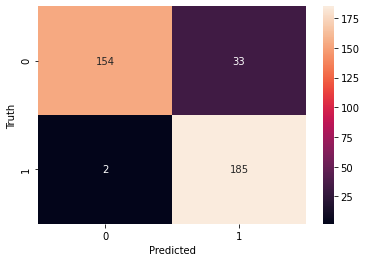

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       187
           1       0.85      0.99      0.91       187

    accuracy                           0.91       374
   macro avg       0.92      0.91      0.91       374
weighted avg       0.92      0.91      0.91       374



<h4>Inference</h4>

In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.8734353 ],
       [0.92858446],
       [0.8960864 ],
       [0.29311982],
       [0.13262196]], dtype=float32)